In [ ]:
#Importer les dossiers
#import density_estimation as de
import samplers as sm

#Importer les bibliothèques de python
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            nn.Linear(32,1),
            nn.Sigmoid()
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)

In [ ]:
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class WNet(nn.Module):
    def __init__(self):
        super(WNet,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            #nn.Linear(32, 32),
            #nn.ReLU(),
            nn.Linear(32,1)
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)

In [ ]:
D = Net()
T = Net()

In [ ]:
def loss_fn1(Discriminator,x,y):
    x = x.to('cuda')
    y = y.to('cuda')
    real_data = torch.mean(torch.log(Discriminator(x)))
    fake_data = torch.mean(torch.log(1 - Discriminator(y)))
    return -(real_data+fake_data)

In [ ]:
def loss_fn2(Discriminator,x,y,lamb=10):
    x = x.to('cuda')
    y = y.to('cuda')
    real_data = torch.mean(Discriminator(x))
    #print("D_real:",real_data)
    fake_data = torch.mean(Discriminator(y))
    #print("D_fake:",real_data)
    a = torch.empty(512, 1).uniform_(0, 1).float().cuda()
    #p = torch.from_numpy(next(sm.distribution1(0))).float()
    #q = torch.from_numpy(next(sm.distribution1(-1))).float()
    
    z = a*x+(1-a)*y
    input = torch.autograd.Variable(z,requires_grad= True)
    output = Discriminator(input)
    grad = torch.autograd.grad(output, input, grad_outputs=torch.ones(output.size()).cuda(),create_graph=True, only_inputs=True, 
    					   retain_graph=True)[0]
    grad = grad.view(512, -1)
    grad = grad.norm(2,dim =1)
    grad = grad - 1
    grad = grad**2
    #grad = torch.sqrt(grad)
    return -(real_data-fake_data-lamb*grad.mean())

In [ ]:
a,b,thet = [],[],[]
cuda = torch.cuda.is_available();
for i in range(21):
    T = WNet().cuda()
    theta = -1 + i*0.1
    thet.append(theta)
    p = sm.distribution1(0, 512)
    q = sm.distribution1(theta,512)
    dist_p = iter(p)
    dist_q = iter(q)
#		dist_q = iter(q)
    optimizer = optim.Adam(T.parameters(), lr=1e-3)
    print('theta:', thet)
    for i in range(5000):
        T.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn2(T,X,Y)
        if ( i%1000 == True):
          print(-loss.data)
        T.zero_grad()
        loss.backward()
        optimizer.step()
    T.eval()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    b.append(-loss_fn2(T,X,Y))

theta: [-1.0]
tensor(-4.1895, device='cuda:0')
tensor(1.0251, device='cuda:0')
tensor(1.0250, device='cuda:0')
tensor(1.0250, device='cuda:0')
tensor(1.0248, device='cuda:0')
theta: [-1.0, -0.9]
tensor(-4.3690, device='cuda:0')
tensor(0.9151, device='cuda:0')
tensor(0.9202, device='cuda:0')
tensor(0.9202, device='cuda:0')
tensor(0.9203, device='cuda:0')
theta: [-1.0, -0.9, -0.8]
tensor(-6.8510, device='cuda:0')
tensor(0.8152, device='cuda:0')
tensor(0.8160, device='cuda:0')
tensor(0.8160, device='cuda:0')
tensor(0.8160, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7]
tensor(-4.1822, device='cuda:0')
tensor(0.7122, device='cuda:0')
tensor(0.7123, device='cuda:0')
tensor(0.7123, device='cuda:0')
tensor(0.7123, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7, -0.6]
tensor(-7.6271, device='cuda:0')
tensor(0.6087, device='cuda:0')
tensor(0.6090, device='cuda:0')
tensor(0.6090, device='cuda:0')
tensor(0.6090, device='cuda:0')
theta: [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5]
tensor(-3.1271, devic

In [ ]:
a,thet = [],[]
cuda = torch.cuda.is_available();
for i in range(21):
    D = Net().cuda()
    theta = -1 + i*0.1
    thet.append(theta)
    p = sm.distribution1(0, 512)
    q = sm.distribution1(theta,512)
    dist_p = iter(p)
    dist_q = iter(q)
#	dist_q = iter(q)
    optimizer = optim.Adam(D.parameters(), lr=1e-3)
    print(thet)
    for i in range(5000):
        D.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn1(D,X,Y)
        
        D.zero_grad()
        if ( i%1000 == True):
          print(-loss.data)
        loss.backward()
        optimizer.step()
    D.eval()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    a.append(-loss_fn1(D,X,Y)/2+np.log(2))
    #b.append(-loss_fn2(T,p,q))

[-1.0]
tensor(-1.4217, device='cuda:0')
tensor(-0.0215, device='cuda:0')
tensor(-0.0038, device='cuda:0')
tensor(-0.0012, device='cuda:0')
tensor(-0.0005, device='cuda:0')
[-1.0, -0.9]
tensor(-1.3909, device='cuda:0')
tensor(-0.0234, device='cuda:0')
tensor(-0.0047, device='cuda:0')
tensor(-0.0017, device='cuda:0')
tensor(-0.0008, device='cuda:0')
[-1.0, -0.9, -0.8]
tensor(-1.1500, device='cuda:0')
tensor(-0.0184, device='cuda:0')
tensor(-0.0038, device='cuda:0')
tensor(-0.0014, device='cuda:0')
tensor(-0.0006, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7]
tensor(-1.3675, device='cuda:0')
tensor(-0.0303, device='cuda:0')
tensor(-0.0059, device='cuda:0')
tensor(-0.0021, device='cuda:0')
tensor(-0.0009, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7, -0.6]
tensor(-1.3863, device='cuda:0')
tensor(-0.0399, device='cuda:0')
tensor(-0.0076, device='cuda:0')
tensor(-0.0027, device='cuda:0')
tensor(-0.0012, device='cuda:0')
[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5]
tensor(-1.3533, device='cuda:0')
tensor(-0.

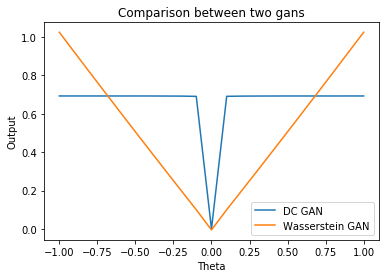

In [ ]:
plt.plot(thet,a,label = "DC GAN")
plt.plot(thet,b,label ="Wasserstein GAN")
plt.xlabel("Theta")
plt.ylabel("Output")
plt.title("Comparison between two gans")
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
for i in range(1):
    D = Net().cuda()
    thet
    thet.append(theta)
    p = sm.distribution3()
    q = sm.distribution4(batch_size = 512)
    dist_p = iter(p)
    dist_q = iter(q)
#	dist_q = iter(q)
    optimizer = optim.Adam(D.parameters(), lr=1e-3)
    print(thet)
    for i in range(5000):
        D.train()
        X = torch.from_numpy(next(dist_p)).float()
        Y = torch.from_numpy(next(dist_q)).float()
        loss = loss_fn1(D,X,Y)
        
        D.zero_grad()
        if ( i%1000 == True):
          print(-loss.data)
        loss.backward()
        optimizer.step()
    D.eval()

[-1.0, -0.9, -0.8, -0.7, -0.6, -1.0, -1.0]
tensor(-1.3257, device='cuda:0')
tensor(-1.1943, device='cuda:0')
tensor(-1.2063, device='cuda:0')
tensor(-1.2284, device='cuda:0')
tensor(-1.1918, device='cuda:0')


tensor(-1.3180)
tensor(-1.2551)
tensor(-1.2027)
tensor(-1.2237)
tensor(-1.2417)


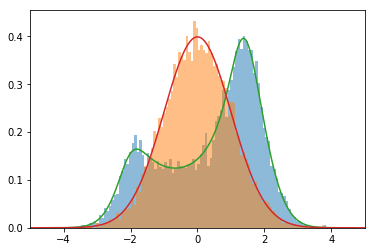

In [ ]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt
import samplers as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
cuda = torch.cuda.is_available()
cuda = False
# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######
def xavier_init(m):
    """ Xavier initialization """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

class WNet(nn.Module):
    def __init__(self):
        super(WNet,self).__init__()
        self.D = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            
            nn.Linear(32,1),
            nn.Sigmoid(),
        )
        self.D.apply(xavier_init)
    def forward(self,input):
        return self.D(input)
D = WNet()
p = sm.distribution3()
q = sm.distribution4(batch_size=512)
dist_p = iter(p)
dist_q = iter(q)

def loss_fn1(Discriminator,x,y):
    x = x.to('cpu')
    y = y.to('cpu')
    real_data = torch.mean(torch.log(1 - Discriminator(x)))
    fake_data = torch.mean(torch.log(Discriminator(y)))
    return -(real_data+fake_data)

optimizer = optim.Adam(D.parameters(), lr=1e-3)

for i in range(5000):
    D.train()
    X = torch.from_numpy(next(dist_p)).float()
    Y = torch.from_numpy(next(dist_q)).float()
    loss = loss_fn1(D,X,Y)
    D.zero_grad()
    if ( i%1000 == True):
        print(-loss.data)
    loss.backward()
    optimizer.step()



In [ ]:
from torch.autograd import Variable
D.eval()
sm.distribution3()
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
f0_x_tensor = Variable(torch.from_numpy(np.float32(xx.reshape(1000, 1))))
#X = torch.from_numpy(next(sm.distribution3(1000))).float().to('cuda')
#print(np.size(np.float32(xx)))
D_x = D(f0_x_tensor)
f1_est = (N(f0_x_tensor) * D_x) / (1 - D_x)

Text(0.5, 1.0, '$D(x)$')

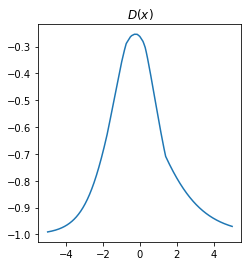

In [ ]:
# Plot the discriminator output.
r = -D_x.detach().numpy() 
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')


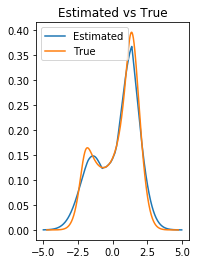

In [ ]:
estimate = f1_est.detach().numpy() 
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
plt.savefig('Estimated_vs_Exact.png') 
plt.show()
